# SCOOTR Tutorial

TO DO:

Make sure to increase nits for emd

In this tutorial, we will examine our newest tool, SCOOTR. SCOOTR blends together UGW and UCOOT to incentivise sample alignments that are  informed by both feature data and local geometry.

```{tip}
If you want to know more about how and why SCOOTR works, see our document on the evolution of optimal transport algorithms for sample alignment. In addition, if you have not yet seen our UGW and UCOOT tutorials, we recommend viewing those first to get a sense of what SCOOTR is doing under the hood.
```

To begin, we will load in our preprocessed data. If you would like to preprocess the data in your own way, you can download the raw files for this dataset by running "sh download_scripts/CITEseq_download.sh" from the root of your SCOOTR directory. They will be loaded into the same folder as the preprocessed datasets.

In [1]:
%%capture
import src.megawass as mw
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import normalize

X_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
y_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
x_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
y_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(X_raw.shape[1])]

ModuleNotFoundError: No module named 'src.megawass'

From here, we can load our data into usable DataFrames.

In [2]:
X_full_annotated = pd.DataFrame(normalize(normalize(X_raw.X, norm='l2', axis=1).transpose(), norm='l2', axis=1))
X_full_annotated.index, X_full_annotated.columns = samp_labels, x_feat_labels
y_full_annotated = pd.DataFrame(normalize(y_raw.transpose().X, norm='l2', axis=1))
y_full_annotated.index, y_full_annotated.columns = samp_labels, y_feat_labels

X_full = X_full_annotated.to_numpy()
y_full = y_full_annotated.to_numpy()

X_annotated = X_full_annotated.iloc[:,0:10]
y_annotated = y_full_annotated.iloc[:,0:10]

X = X_annotated.to_numpy()
y = y_annotated.to_numpy()

NameError: name 'pd' is not defined

From here, we can instantiate a MegaWass object to begin aligning our data.

```{tip}
See our setup tutorial to get a better understanding of the initial parameters for the MegaWass tool.
```

In [3]:
megawass = mw.MegaWass(nits_bcd=10)

From here, we can begin by establishing pairwise distance matrices for our domains, as per the UGW tutorial:

In [4]:
X_full=np.load("./data/CITEseq/cite_adt_1000cells.npy")
y_full=np.load("./data/CITEseq/cite_rna_1000cells.npy")

X_full=normalize(np.transpose(X_full))
y_full=normalize(np.transpose(y_full))

In [5]:
# knn connectivity distance
Dx_knn = megawass.compute_graph_distances(X_full, n_neighbors=10,mode='connectivity')
Dy_knn = megawass.compute_graph_distances(y_full, n_neighbors=10, mode='connectivity')

In [6]:
Dx_knn

array([[ 0., 17.,  2., ..., 17., 17.,  4.],
       [17.,  0., 15., ...,  4.,  2., 16.],
       [ 2., 15.,  0., ..., 15., 15.,  3.],
       ...,
       [17.,  4., 15., ...,  0.,  4., 16.],
       [17.,  2., 15., ...,  4.,  0., 16.],
       [ 4., 16.,  3., ..., 16., 16.,  0.]])

In [7]:
Dx_knn = megawass.knn_dist(X_full, k=10)

In [8]:
Dx_knn

array([[0.        , 0.89473684, 0.10526316, ..., 0.89473684, 0.89473684,
        0.21052632],
       [0.89473684, 0.        , 0.78947368, ..., 0.21052632, 0.10526316,
        0.84210526],
       [0.10526316, 0.78947368, 0.        , ..., 0.78947368, 0.78947368,
        0.15789474],
       ...,
       [0.89473684, 0.21052632, 0.78947368, ..., 0.        , 0.21052632,
        0.84210526],
       [0.89473684, 0.10526316, 0.78947368, ..., 0.21052632, 0.        ,
        0.84210526],
       [0.21052632, 0.84210526, 0.15789474, ..., 0.84210526, 0.84210526,
        0.        ]])

Now we can try a standard SCOOTR alignment.

In [6]:
(pi_samp, pi_feat), _, log = megawass.agw_scootr(X_full, y_full, Dx_knn, Dy_knn, alpha=0.1, sample_eps=0.001, feature_eps=0.005, verbose=True, log=True)
log

/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/ot/lp/__init__.py:346: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:709: RuntimeWarning: divide by zero encountered in scalar divide
  alpha2 = (-b + np.sqrt(abs(b**2 - 3 * a * derphi0))) / (3.0*a)
/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


NonConvergenceError: Alpha not found

NameError: name 'pi_samp' is not defined

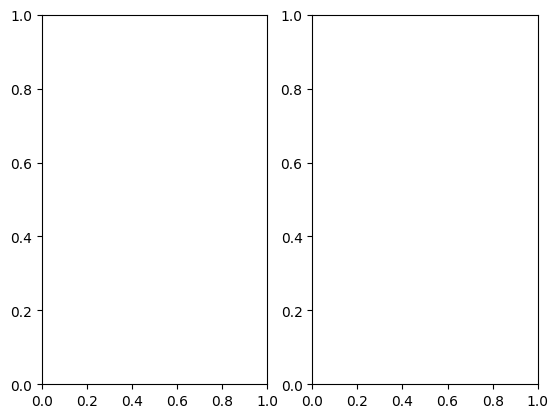

In [7]:
import seaborn as sns

_, (ax1, ax2) = plt.subplots(1, 2)

sns.heatmap(pi_samp, ax=ax1, cmap='rocket_r', square=True)
sns.heatmap(pi_feat, ax=ax2, cmap='rocket_r', square=True)